In [1]:
################################################
# Ayoub Sikouky
# Title: SISR Using a Multi Model System
# Edit Date: 25/04/2022
# Github Repo: https://github.com/AYSIK0/Super_resolution_Project
################################################
import os
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, Rescaling, Add, Lambda, Flatten, Dense, LeakyReLU, BatchNormalization 
from tensorflow.keras.losses import MeanAbsoluteError, BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from tensorflow.keras.metrics import Mean
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import time
from PIL import Image
from typing import List

## I - Data

### 1.1 : Helper Functions

In [2]:
def download_data(f_name, dst, source_url):
    """
    Download and unzip datastes.
    #### Args:
    f_name: zip file name.
    dst: The destination directory where the files will be stored.
    source_url: The URL for the dataset.
    """
    file_url = os.path.join(source_url, f_name)
    dst_abspath = os.path.abspath(dst)
    tf.keras.utils.get_file(f_name, file_url, cache_subdir=dst_abspath, extract=True)
    # Removing the zip file.
    os.remove(os.path.join(dst_abspath, f_name)) 


def get_paths(dirs: List[str], path_type):
    """
    Retuns a list of images' paths inside a directories 
    that have "path_type" in their name.
    #### Args:
    dirs: The list of directories to be searched.
    path_type: The "characters" to selcet which directories to search for images.
    """
    if not isinstance(dirs, list):
      raise Exception("'dirs' argument must be a list.")

    paths_list = [] # List of paths in "dirs"
    subpaths_lists = [] # List of lists of images' paths.
    for d in dirs:
      if path_type in str(d):
        paths_list.append(d)
    paths_list.sort()
    
    if len(paths_list) == 1:
        img_paths = [str(f) for f in paths_list[0].glob("**/*.png")]
        img_paths.sort()
        return img_paths
    else:
      for main_path in paths_list:
        tmp_subpath_list = [str(f) for f in main_path.glob("**/*.png") if f.is_file]
        tmp_subpath_list.sort()
        subpaths_lists.append(tmp_subpath_list)

    return subpaths_lists

### 1.2: Preparing the Data

#### 1.2.1 Download Data (if needed)

In [5]:
# Downloading the datasets used in training and validation.
if not os.path.exists("Original_Datasets/DIV2K"):

    DIV2K_URL = "http://data.vision.ee.ethz.ch/cvl/DIV2K/"
    DIV2K_FILE_NAMES = ["DIV2K_train_HR.zip", "DIV2K_valid_HR.zip", 
                        "DIV2K_train_LR_bicubic_X2.zip", "DIV2K_valid_LR_bicubic_X2.zip"]
    dst_dir = "Original_Datasets/DIV2K"

    for file in DIV2K_FILE_NAMES:
        download_data(file, dst_dir, DIV2K_URL)
else:
    print("'Original_Datasets/DIV2K' Exists")

'Original_Datasets/DIV2K' Exists


#### 1.2.2 Data Paths

In [6]:
# Check if colab is used.
using_google_colab = "google.colab" in str(get_ipython())

## When Using Google Colab
if using_google_colab:
  from google.colab import drive
  drive.mount('/content/drive')
  colab_path = "/content/drive/MyDrive/ARU's Master/Application Of Machine Learning/Assignments/Super_Resolution/"
  ALL_DATA_PATH = Path(colab_path+"Original_Datasets")
  CHECKPOINT_PATH = colab_path + "training_checkpoints/"
  MODELS_PATH = colab_path + "Models/"

else:
## When Using Local Machine.
  ALL_DATA_PATH = Path(r"Original_Datasets")
  CHECKPOINT_PATH = "training_checkpoints/"
  MODELS_PATH = "Models/"

In [7]:
SCALE = 2 # The scale of the downsample images used.
SCALING_TO_UPSAMPLE = {2: 1, 3: 1, 4: 2}

# Getting all sub directories inside the working directory.
all_paths = ALL_DATA_PATH.glob("**/*")
dirs = [d for d in all_paths if d.is_dir()]

# Selecting HR (High Resolution) directories.
all_sub_paths = get_paths(dirs, "HR")

# 
HR_TRAIN_PATH, HR_VALID_PATH = all_sub_paths[0], all_sub_paths[1]
print(f"HR Train Len: {len(HR_TRAIN_PATH)}")
print(f"HR Valid Len: {len(HR_VALID_PATH)}")
print(f"HR Train Paths Example:\n{HR_TRAIN_PATH[:2]}")

LR_TRAIN_PATH, LR_VALID_PATH = get_paths(dirs, f"X{SCALE}")
print(f"LR Train Len: {len(LR_TRAIN_PATH)}")
print(f"LR Valid Len: {len(LR_VALID_PATH)}")
print(f"LR Train Paths Example:\n{LR_TRAIN_PATH[:2]}")

HR Train Len: 800
HR Valid Len: 100
HR Train Paths Example:
['Original_Datasets/DIV2K/DIV2K_train_HR/0001.png', 'Original_Datasets/DIV2K/DIV2K_train_HR/0002.png']
LR Train Len: 800
LR Valid Len: 100
LR Train Paths Example:
['Original_Datasets/DIV2K/DIV2K_train_LR_bicubic/X2/0001x2.png', 'Original_Datasets/DIV2K/DIV2K_train_LR_bicubic/X2/0002x2.png']


#### 1.2.3 Creating the datasets used in the models

In [8]:
def load_img(file_name:str):
    """
    Read and load an image (Dtype=int32)from a file name.
    #### Args:
    file_name: The image file name.
    """
    img = tf.image.decode_image(tf.io.read_file(file_name), channels=3)
    return tf.cast(img, tf.int32)

def random_crop(lr_img, hr_img, hr_crop_size, scale, same_size=False):
    """
    Randomly crop images.
    #### Args:
    lr_img: Low-resolution image.
    hr_img: High-resolution image.
    hr_crop_size: The crop size for the HR image.
    scale: The scale of the LR image wrt HR image.
    same_size: Wehther the images have the same size.
    """
    hr_shape = tf.shape(hr_img)
    
    # To include the last columns and rows of pixels '+ 1' is needed.
    # Dtype is int32 to be able to use indices to crop the image.
    # Randomly selecting a value between [0 and hr_crop_size+1).
    hr_top = tf.random.uniform(shape=(), maxval=hr_shape[0] - hr_crop_size + 1, dtype=tf.int32)
    hr_left = tf.random.uniform(shape=(), maxval=hr_shape[1] - hr_crop_size + 1, dtype=tf.int32)

    # Calculating the crop size for low resolution image.
    if not same_size:
        lr_crop_size = hr_crop_size // scale
        lr_top = hr_top // scale
        lr_left = hr_left // scale
    else:
        lr_crop_size = hr_crop_size
        lr_top = hr_top
        lr_left = hr_left

    # Cropping the images.
    lr_img_crop = lr_img[lr_top:lr_top + lr_crop_size, lr_left:lr_left + lr_crop_size]
    hr_img_crop = hr_img[hr_top:hr_top + hr_crop_size, hr_left:hr_left + hr_crop_size]

    return lr_img_crop, hr_img_crop

def random_flip(lr_img, hr_img):
    """
    Randomly flip the image horizantally and vertically.
    #### Args:
    lr_img: Low resolution image.
    hr_img: High resolution image.
    """
    rng = np.random.default_rng()
    # Horizantal Flip
    ran_value = rng.uniform(low=0, high=1, size=1)[0]
    if ran_value >= 0.5:
        lr_img = tf.image.flip_left_right(lr_img)
        hr_img = tf.image.flip_left_right(hr_img)
    # Vertical Flip
    ran_value = rng.uniform(low=0, high=1, size=1)[0]
    if ran_value >= 0.5:
        lr_img = tf.image.flip_up_down(lr_img)
        hr_img = tf.image.flip_up_down(hr_img)
    return lr_img, hr_img

def random_rotation(lr_img, hr_img):
    """
    Randomly rotate the image.
    #### Args:
    lr_img: Low resolution image.
    hr_img: High resolution image.
    """
    rng = np.random.default_rng()
    ran_value = rng.uniform(low=0, high=1, size=1)[0]
    if ran_value >= 0.5:
        num_rot = rng.integers(low=0, high=4, size=1)[0]
        """
        num_rot:
        0 rotation, 0 degrees.
        1 rotation, 90 degrees.
        2 rotations, 180 degrees.
        3 rotations, 270 degrees.
        """
        lr_img = tf.image.rot90(lr_img, k=num_rot)
        hr_img = tf.image.rot90(hr_img, k=num_rot)
    return lr_img, hr_img 

def convert_dtype(lr_img, hr_img, dtype=tf.float32):
    """
    Convert the type of images.
    #### Args:
    lr_img: Low resolution image.
    hr_img: High resolution image.
    dtype: The new type of images.
    """
    lr_img = tf.cast(lr_img, dtype)
    hr_img = tf.cast(hr_img, dtype)
    return lr_img, hr_img

def create_dataset(lr_paths: List[str], hr_paths: List[str], batch_size:int=16, 
                   crop_size=96, scale:int=None, same_size=False, apply_trans=True, repeat=None):
    """
    Create an optimised dataset to be used with a model.
    #### Args:
    lr_paths: List of Low-resolution images.
    hr_paths: List of High-resolution images.
    batch_size: The batch size used in the dataset.
    crop_size: The crop size used for cropping the HR images; deafult=96.
    scale: The scaling factor. 
    same_size: Wehther the images have the same size.
    apply_trans: Whether to apply transformations; default=True.
    repeat: The number of time the dataset will be repeated;
             deafult=None, the dataset will be repeated indefinitely.
    """
    
    if not scale or scale < 2:
        raise ValueError(f"Scale must be an integer and >= 2, got '{scale}'")

    # A variable used by tensorflow data API to 
    # dynamically select the best value for its operation.
    AUTOTUNE = tf.data.AUTOTUNE 

    imgs_paths = [lr_paths, hr_paths]
    dataset_list = []

    for type_path in imgs_paths:
        tmp_ds = tf.data.Dataset.from_tensor_slices(type_path)
        tmp_ds = tmp_ds.map(load_img, num_parallel_calls=AUTOTUNE)
        dataset_list.append(tmp_ds)

    # Creating the dataset by zipping together the LR and HR datasets.
    dataset = tf.data.Dataset.zip((dataset_list[0], dataset_list[1]))

    # Performing data augmentation.
    if apply_trans:
        dataset = dataset.map(lambda lr, hr: random_crop(lr, hr, crop_size, scale, same_size=same_size), num_parallel_calls=AUTOTUNE)
        dataset = dataset.map(random_flip, num_parallel_calls=AUTOTUNE)
        dataset = dataset.map(random_rotation, num_parallel_calls=AUTOTUNE)
    
    dataset = dataset.batch(batch_size, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(convert_dtype, num_parallel_calls=AUTOTUNE) # Converting images to float32.
    dataset = dataset.repeat(repeat) # Keeps generating data.
    dataset = dataset.prefetch(AUTOTUNE) # prefecth data to speedup training.
    return dataset

In [10]:
BATCH_SIZE = 16

train_dataset = create_dataset(LR_TRAIN_PATH, HR_TRAIN_PATH, batch_size=BATCH_SIZE, 
                               crop_size=96, scale=SCALE, same_size=False, apply_trans=True)

valid_dataset = create_dataset(LR_VALID_PATH, HR_VALID_PATH, batch_size=1, 
                                scale=SCALE, apply_trans=False, repeat=1)

LR Batch: 
(TensorShape([16, 48, 48, 3]), tf.float32)
HR Batch: 
(TensorShape([16, 96, 96, 3]), tf.float32)


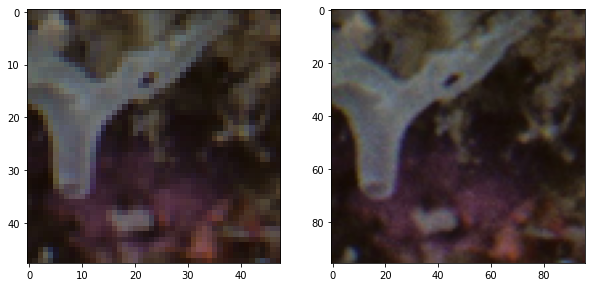

In [13]:
# Example of the produced datasets.
for img_batch in train_dataset.take(1):
    lr_batch, hr_batch = img_batch
    lr_img = lr_batch[0]
    hr_img = hr_batch[0]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(tf.cast(lr_img, tf.uint8))
    plt.subplot(1, 2, 2)
    plt.imshow(tf.cast(hr_img, tf.uint8))
    
    print(f"LR Batch: \n{lr_batch.shape, lr_batch.dtype}")
    print(f"HR Batch: \n{hr_batch.shape, hr_batch.dtype}")

## II - Models

In [14]:
base_model_name = "2X_base_model.h5"
gan_gen_model_name = "2X_GAN_gen_model.h5"
gan_dis_model_name = "2X_GAN_dis_model.h5"

### 2.1 Helper Functions

In [15]:
########################## General Helper Functions ########################## 
def psnr_metric(org_img, up_img):
    """
    Calculate PSNR between the two images.
    #### Args:
    org_img: Original image.
    up_img: Upsampled image.
    """
    return tf.image.psnr(org_img, up_img, max_val=255)

def ssim_metric(org_img, up_img):
    """
    Calculate SSIM between the two images.
    #### Args:
    org_img: Original image.
    up_img: Upsampled image.
    """
    return tf.image.ssim(org_img, up_img, max_val=255)

def plot_metric(m_history, metric: str, val=True):
  """
  Plots a metric of a model.
  #### Args:
  m_history: Model History.
  metric: The metric name to plot.
  val: Whether to include the validation metrics.
  """
  train_metric = m_history.history[metric]
  if val:
    val_metric = m_history.history["val_"+metric]

  num_epochs = range(1, len(train_metric)+1)
  plt.plot(num_epochs, train_metric)
  if val:
    plt.plot(num_epochs, val_metric)
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  if val:
    plt.title(f"Train and Validation: {metric}")
    plt.legend(["Train", "Validation"], loc="best")
  else:
    plt.title(f"Train : {metric}")
    plt.legend(["Train"], loc="best")
  
  plt.show()

def multi_save(t_model, model_fname: str, model_dir: str, t_history, show_dir=False):
    """
    Save the model, and its history as a json file.
    #### Args:
    t_model: Model to save.
    model_name: The name given to the model.
    model_dir: Directory where the to save the model and history file.
    t_history: Model history.
    """
    try:
        # Model name without the extinsion
        m_name = model_fname.split('.')[0]

        t_model.save(model_dir+model_fname)
        print(f"{m_name} Was saved.")
        
        with open(model_dir+f"{m_name}_t_history_dict.json", 'w') as th_file:
            json.dump(t_history.history, th_file)
        print(f"{m_name} history was saved.")
        if show_dir:
          print(f"Model and history were saved in: '{model_dir}'")
    except Exception as e:
        print(e)

In [16]:
########################## Base Line Model Helper Functions (N.B Run also for GAN) ##########################
def get_upsample_num(scaling_dict, scale):
    """
    Return the number of upscaling blocks needed based on the scale factor.
    #### Args:
    scaling_dict: A dictionary for mapping scaling factors to the number 
                  of upscaling needed to achieve the upscaling.
    scale: The sacle factor.
    """
    try:
        return scaling_dict[scale]
    except KeyError:
        raise KeyError("Only 2, 3, and 4 are supported as a scale.")

def create_resblock(in_layer, num_filters, kernel_size=3):
    """
    Build the residual blocks.
    #### Args:
    in_layer: Layer to build on top of it.
    num_filters: Number of filters in the convolutional layer.
    kernel_size: The kernel size in the convolutional layer.
    """
    x = Conv2D(num_filters, kernel_size=kernel_size, padding="same", activation="relu")(in_layer)
    x = Conv2D(num_filters, kernel_size, padding="same")(x)
    x = Add()([in_layer, x])
    return x
    
def upsample_block(in_layer, num_filters, scale):
    """
    Build the upsampling blocks.
    #### Args:
    in_layer: Layer to build on top of it.
    num_filters: Number of filters in the convolutional layer.
    scale: Scaling factor.
    """
    x = Conv2D(num_filters*(scale**2), kernel_size=3, padding='same')(in_layer)
    x = Lambda(lambda z: tf.nn.depth_to_space(z, scale))(x)
    return x

def create_base_model(scale, scaling_dict, filters=64, k_size=9, resblocks=16):
    """
    Build the base model.
    #### Args:
    scale: Scaling factor.
    scaling_dict: A dictionary for mapping scaling factors to the number 
                  of upscaling needed to achieve the upscaling.
    filters: Number of filters in the convolutional layers.
    k_size: Kernel size used in the first convolutional layer.
    resblocks: Number of residual blocks.
    """
    if not scale or scale < 2:
        raise ValueError(f"Scale must be an integer and >= 2, got '{scale}'")
    # Number of upscaling factors.
    n_upscaling_blocks = get_upsample_num(scaling_dict, scale)

    ######################## Initial Part ########################
    x_input = Input(shape=(None, None, 3))
    # Ensuring that the model can accept any image size.
    assert x_input.shape.as_list() == [None, None, None, 3]
    # Normalising the image to [-1, 1]
    x = Rescaling(1./127.5, offset=-1)(x_input)
    x = conv1 = Conv2D(filters=filters, kernel_size=k_size, 
                        padding="same")(x)

    ######################## Residual Part ########################
    # Creating the residual blocks.
    for _ in range(resblocks):
        x = create_resblock(x, num_filters=filters, kernel_size=3)
    
    x = Conv2D(filters, 3, padding="same")(x)
    x = Add()([conv1, x])

    ######################## Upsampling Part ########################
    if scale % 2 == 0:
        scale = 2
    for _ in range(n_upscaling_blocks):
        x = upsample_block(x, filters, scale)

    ######################## Output ########################
    x = Conv2D(3, k_size, padding="same")(x)
    return Model(inputs=x_input, outputs=x, name="base_model")

In [17]:
########################## Gan Model Helper Functions ##########################
def create_disc_block(in_layer, k_size, filters, stride, bn=True):
    """
    Build the discriminator convolutional blocks.
    #### Args:
    in_layer: Layer to build on top of it.
    k_size: The kernel size in the convolutional layer.
    filters: Number of filters in the convolutional layer.
    stride: Stride size in the convolutional layer.
    bn: Whether to include batch normalization.
    """
    layer = Conv2D(filters, k_size, stride)(in_layer)
    if bn:
        layer = BatchNormalization()(layer)
    layer = LeakyReLU(alpha=0.2)(layer)
    return layer

def create_discriminator(img_size):
    """
    Build the discriminator part in the GAN.
    #### Args:
    img_size: The input image size. 
    """
    x_input = Input(shape=(img_size, img_size, 3))
    # Normalising the image to [-1, 1]
    x = Rescaling(1./127.5, offset=-1)(x_input)

    x = create_disc_block(x, 3, 64, 1, bn=False)
    x = create_disc_block(x, 3, 64, 2)
    
    x = create_disc_block(x, 3, 128, 1)
    x = create_disc_block(x, 3, 128, 2)
    
    x = create_disc_block(x, 3, 256, 1)
    x = create_disc_block(x, 3, 256, 2)
    
    x = create_disc_block(x, 3, 512, 1)
    x = create_disc_block(x, 3, 512, 2)

    x = Flatten()(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1, activation="sigmoid")(x)

    return Model(x_input, x)

def create_generator(up_model, res_blocks:int=16):
    """
    Build the generator part in the GAN.
    #### Args:
    up_model: The trained upscaling model.
    res_blocks: The number of residual blocks.
    """
    ########################### Upscaling Part ###########################
    up_model.trainable = False
    gen_input = Input(shape=(None, None, 3))
    # Ensuring that the model can accept any image size.
    assert gen_input.shape.as_list() == [None, None, None, 3]

    # Using the trained model to upscale the image.
    y = up_model(gen_input)
    # Normalising the image to [-1, 1]
    x = Rescaling(1./127.5, offset=-1)(y)

    ########################### Refining Part ###########################
    x = conv1 = Conv2D(filters=64, kernel_size=9, padding="same")(x)
    for _ in range(res_blocks):
        x = create_resblock(x, num_filters=64, kernel_size=3)
    x = Conv2D(64, 3, padding="same")(x)
    x = Add()([conv1, x])
    
    ########################### Output ###########################
    x = Conv2D(3, 9, padding="same")(x)

    return Model(inputs=gen_input, outputs=x, name="generator")

def get_perceptual_model(t_model, ith_layer: int):
    """
    Create the model used to generate the fetaure maps 
    to be used in perceptual loss.
    #### Args:
    t_model: Trained model to use.
    ith_layer: Number of the conv layer in the trained model.
    """
    # 5: the conv layer before the second max pooling.
    # 20: the last conv layer before the last max pooling.
    if ith_layer not in [5, 20]:
        raise ValueError("'ith_layer can only be 5 or 20!!")
    # The complete trained model.
    trained_model = t_model(input_shape=(None, None, 3), include_top=False)
    # Creating a model that wil produce the feature maps' from 
    # the 'ith_layer' of the trained model.
    perceptual_model = Model(trained_model.input, trained_model.layers[ith_layer].output)
    perceptual_model.trainable = False
    return perceptual_model

# Loss functions
binary_cross_entropy = BinaryCrossentropy()
mse = MeanSquaredError()
@tf.function
def cal_content_loss(rf_img, hr, perceptual_model):
    """
    Calculate the content loss as described in SRGAN paper.
    #### Args:
    rf_img: Refined image created by the generator.
    hr: High resolution image.
    perceptual_model: Model to use in calculating the loss.
    """
    rf = preprocess_input(rf_img)
    hr = preprocess_input(hr)
    # Divide by 12.75 to get a loss that is comparable to MSE loss, as stated in SRGAN paper.
    rf_features = perceptual_model(rf) / 12.75 
    hr_features = perceptual_model(hr) / 12.75
    return mse(hr_features, rf_features)

def cal_gen_loss(rf):
    """
    Calculate the initial generator loss.
    #### Args:
    rf: Refined image created by the generator.
    """
    return binary_cross_entropy(tf.ones_like(rf), rf)

def cal_disc_loss(rf_out, hr_out):
    """
    Calculate the discriminator loss.
    #### Args:
    rf_out: The discrminator output from the refined image.
    hr_out: The discrminator output from the HR image.
    """
    hr_loss = binary_cross_entropy(tf.ones_like(hr_out), hr_out)
    rf_loss = binary_cross_entropy(tf.zeros_like(rf_out), rf_out)
    return hr_loss + rf_loss



### 2.2 Base Model

In [18]:
base_model = create_base_model(SCALE, SCALING_TO_UPSAMPLE, filters=64, k_size=9, resblocks=16)

In [13]:
base_model.summary()

Model: "base_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   15616       ['rescaling[0][0]']              
                                64)                                                      

In [ ]:
# Display The base model architecture.
tf.keras.utils.plot_model(base_model, dpi=200, to_file=MODELS_PATH+"base_model_architecture.png")

In [30]:
# Callbacks
my_checkpoint_callback = ModelCheckpoint(filepath=CHECKPOINT_PATH+"base_model/weights.{epoch:02d}-{val_loss:.2f}.h5", 
                                         save_weights_only=True,
                                         monitor="val_loss",
                                         mode='min',
                                         save_best_only=True,
                                         initial_value_threshold=7.0)

my_callbacks = [my_checkpoint_callback]


training_updates = 12500
steps_per_epoch = 50
training_epochs = int(training_updates / steps_per_epoch)
print(f"Total training Epochs: {training_epochs}")

Total training Epochs: 250


In [32]:
# 1e-4 from epoch 0 to 200. 
# 1e-5 from epoch 201 to 250.
learning_rate = PiecewiseConstantDecay([10000], [1e-4, 1e-5]) 
base_model.compile(optimizer=Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999,epsilon=1e-8), 
                   loss=MeanAbsoluteError(), 
                   metrics=[psnr_metric])

In [16]:
history = base_model.fit(train_dataset,validation_data=valid_dataset.take(10), 
                         steps_per_epoch=steps_per_epoch, epochs=training_epochs, callbacks=my_callbacks)

Epoch 1/250


2022-04-24 00:52:46.174410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 56.8889 - psnr_metric: 12.3955

2022-04-24 00:52:56.158514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 24s 444ms/step - loss: 56.8889 - psnr_metric: 12.3955 - val_loss: 40.2051 - val_psnr_metric: 14.3911
Epoch 2/250
50/50 [==============================] - 24s 487ms/step - loss: 39.4185 - psnr_metric: 15.0318 - val_loss: 36.7725 - val_psnr_metric: 15.1400
Epoch 3/250
50/50 [==============================] - 23s 467ms/step - loss: 32.8638 - psnr_metric: 16.5746 - val_loss: 27.8480 - val_psnr_metric: 17.5167
Epoch 4/250
50/50 [==============================] - 23s 457ms/step - loss: 25.3239 - psnr_metric: 18.5175 - val_loss: 21.4027 - val_psnr_metric: 19.5253
Epoch 5/250
50/50 [==============================] - 23s 472ms/step - loss: 22.0362 - psnr_metric: 19.9766 - val_loss: 16.0246 - val_psnr_metric: 21.6844
Epoch 6/250
50/50 [==============================] - 24s 482ms/step - loss: 16.3298 - psnr_metric: 22.1953 - val_loss: 14.3484 - val_psnr_metric: 22.5617
Epoch 7/250
50/50 [==============================] - 24s 475ms/step - loss: 16.7201 - ps

In [17]:
# Saving the model and its history.
multi_save(base_model, base_model_name, MODELS_PATH, history, show_dir=True)

2X_base_model Was saved.
2X_base_model history was saved.
Model and history were saved in: 'Models/'


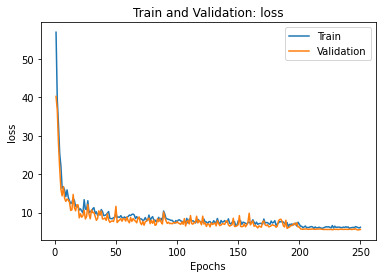

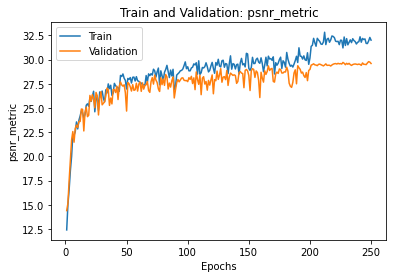

In [18]:
plot_metric(history, "loss")
plot_metric(history, "psnr_metric")

### 2.3 GAN Model

In [13]:
base_model = load_model(MODELS_PATH+base_model_name, custom_objects={"psnr_metric": psnr_metric})

In [14]:
# Create the generator.
generator = create_generator(base_model, res_blocks=16)
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 model (Functional)             (None, None, None,   1397507     ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['model[0][0]']                  
                                3)                                                        

In [ ]:
# Display The generator architecture.
tf.keras.utils.plot_model(generator, dpi=200, to_file=MODELS_PATH+"GAN_gen_architecture.png")

In [60]:
# Create the discriminator.
discriminator = create_discriminator(img_size=96)
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_36 (Conv2D)          (None, 94, 94, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 94, 94, 64)        0         
                                                                 
 conv2d_37 (Conv2D)          (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                             

In [ ]:
# Display The discriminator architecture.
tf.keras.utils.plot_model(discriminator, dpi=200, to_file=MODELS_PATH+"GAN_dis_architecture.png")

In [16]:
gan_learning_rate = PiecewiseConstantDecay([4000], [1e-4, 1e-5])

generator.compile(optimizer=Adam(learning_rate=gan_learning_rate, beta_1=0.9, beta_2=0.999,epsilon=1e-8))
discriminator.compile(optimizer=Adam(learning_rate=gan_learning_rate, beta_1=0.9, beta_2=0.999,epsilon=1e-8))

In [17]:
# Train step for the GAN model.
@tf.function
def train_step(lr_img, hr_img, p_model):
    """
    Used to train the GAN model for one step.
    #### Args:
    lr_img: Low-resolution image.
    hr_img: High-resolution image.
    p_model: Perceptual model used for calcluating the content loss.
    """
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Converting the image data type to float32.
        lr_img = tf.cast(lr_img, tf.float32)
        hr_img = tf.cast(hr_img, tf.float32)

        ##################### Generating the refined upscaled image #####################
        rf_img = generator(lr_img, training=True)

        ##################### Get Discriminator output #####################
        d_hr_out = discriminator(hr_img, training=True) # Real
        d_rf_out = discriminator(rf_img, training=True) # Fake

        ##################### Calculate the losses #####################
        # Generator Loss
        con_loss = cal_content_loss(rf_img, hr_img, p_model)
        gen_loss = cal_gen_loss(d_rf_out)
        perceptual_loss = con_loss + (0.001 * gen_loss) 
        # Discriminator Loss
        disc_loss = cal_disc_loss(d_rf_out, d_hr_out)

        ##################### Calculate the gradients #####################
        gen_gradients = gen_tape.gradient(perceptual_loss, generator.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        ##################### Update the parameters #####################
        generator.optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
        discriminator.optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

        return perceptual_loss, disc_loss

def train_gan(train_ds, valid_ds, p_model=None, epochs=10, cycle=50):
    """
    Train the generator and discriminator for "train_steps" times.
    #### Args:
    train_ds:
    valid_ds:
    p_model:
    epochs:
    cycle: Number of updates to complete the epoch. 
    """
    if p_model == None:
        raise Exception(f"p_model is {p_model}, it must be an actual model.")
    # Perceptual Loss Metric
    p_loss_metric = Mean()
    # Discriminator Loss Metric
    d_loss_metric = Mean()
    n_train_steps = epochs * cycle
    step = 0

    print("Start Training...")
    for lr, hr in train_ds.take(n_train_steps):
        start = time.perf_counter()
        step += 1
        p_loss, d_loss = train_step(lr, hr, p_model)
        
        p_loss_metric(p_loss)
        d_loss_metric(d_loss)

        # After 50 steps (1 epoch) the model would have seen the whole 
        # training set (800 image) if it was not infinte.
        if step % 50 == 0:
            psnr_values = []
            # Performing validation.
            for lr, hr in valid_ds.take(10):
                img_out = generator.predict(lr)[0]
                img_out = tf.clip_by_value(img_out, 0, 255)
                psnr_v = psnr_metric(hr, img_out)[0]
                psnr_values.append(psnr_v)
                psnr = tf.reduce_mean(psnr_values)

            duration = time.perf_counter() - start
                
            print(f"Epoch {step//50}/{epochs}: {duration:.2f}s - perceptual_loss: {p_loss_metric.result():.4f} - ", 
                                                   f"discriminator_loss: {d_loss_metric.result():.4f} - ",
                                                   f"PSNR: {psnr:.4f}")
            p_loss_metric.reset_states()
            d_loss_metric.reset_states() 
    

In [18]:
perc_model = get_perceptual_model(VGG19, 20)
train_gan(train_dataset, valid_dataset, perc_model, epochs=100, cycle=50)

Start Training...


2022-04-24 07:41:17.273172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-24 07:41:53.500347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-24 07:42:02.216525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-24 07:42:06.604479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100: 39.18s - perceptual_loss: 0.2480 -  discriminator_loss: 0.6748 -  PSNR: 7.7663
Epoch 2/100: 37.12s - perceptual_loss: 0.1860 -  discriminator_loss: 0.1223 -  PSNR: 6.5982
Epoch 3/100: 37.11s - perceptual_loss: 0.1830 -  discriminator_loss: 0.0691 -  PSNR: 6.7494
Epoch 4/100: 37.31s - perceptual_loss: 0.1753 -  discriminator_loss: 0.0518 -  PSNR: 6.4557
Epoch 5/100: 37.79s - perceptual_loss: 0.1830 -  discriminator_loss: 0.0972 -  PSNR: 6.3074
Epoch 6/100: 37.34s - perceptual_loss: 0.1720 -  discriminator_loss: 0.0109 -  PSNR: 6.2544
Epoch 7/100: 37.29s - perceptual_loss: 0.1655 -  discriminator_loss: 0.0048 -  PSNR: 6.4406
Epoch 8/100: 37.90s - perceptual_loss: 0.1628 -  discriminator_loss: 0.0042 -  PSNR: 6.4843
Epoch 9/100: 37.09s - perceptual_loss: 0.1740 -  discriminator_loss: 0.0024 -  PSNR: 7.2490
Epoch 10/100: 37.52s - perceptual_loss: 0.1506 -  discriminator_loss: 0.9239 -  PSNR: 9.8821
Epoch 11/100: 37.09s - perceptual_loss: 0.1316 -  discriminator_loss: 0.4498 - 

In [19]:
generator.save(MODELS_PATH+gan_gen_model_name)
discriminator.save(MODELS_PATH+gan_dis_model_name)

## III - Evaluation

### 3.1 Helper Functions

In [27]:
def resize_img(img, img_size, dtype=tf.float32):
    """
    Resise an image to the specified new size.
    #### Args:
    img: The supplied image.
    img_size: New image size.
    dtype: The output image type.
    """
    img = tf.cast(img.numpy(), tf.uint8).numpy()
    img = np.asarray(Image.fromarray(img).resize(img_size, resample=Image.BICUBIC))
    img = tf.clip_by_value(img, 0, 255)
    img = tf.cast(img, dtype)
    return img

def calculate_metrics_list(imgs_paths: List[str], scale: int, model):
    """
    Calculate PSNR and SSIM for all images supplied.
    #### Args:
    imgs_paths: A list of images path.
    scale: The sacling factor to use.
    model: A trained model to generate images.
    """
    if not scale or scale < 2:
        raise ValueError(f"'Scale' must be an integer and >= 2; got {scale}")
    num_imgs = len(imgs_paths)
    total_psnr_bicubic = 0
    total_ssim_bicubic = 0
    total_ssim_model = 0
    total_psnr_model = 0

    for img_path in imgs_paths:
        orig_img = load_img(img_path)
        orig_img = tf.cast(orig_img, dtype=tf.float32)

        lr_height = orig_img.shape[0]//scale
        lr_width = orig_img.shape[1]//scale

        # Hot Fix for images with odd width, height.
        if orig_img.shape[0] % 2 != 0 or orig_img.shape[1] % 2 != 0:
            orig_img = tf.image.resize(orig_img, [lr_height*scale, lr_width*scale])

        # Creatng the low resolution image.
        lr_img = resize_img(orig_img, (lr_width, lr_height))
        
        # Upscaling the LR image using bicubic.
        hr_bicubic = resize_img(lr_img, (orig_img.shape[1], orig_img.shape[0]))

        # Upscaling the LR image using the model.
        hr_model_upsampling = model.predict(tf.expand_dims(lr_img, axis=0))
        hr_model_upsampling = tf.squeeze(hr_model_upsampling, axis=0)
        hr_model_upsampling = tf.clip_by_value(hr_model_upsampling, 0, 255)
        
        # Calculating PSNR and SSIM for bicubic and model generated images.
        total_psnr_bicubic += tf.image.psnr(orig_img, hr_bicubic, 255).numpy()
        total_ssim_bicubic += tf.image.ssim(orig_img, hr_bicubic, 255).numpy()
        total_ssim_model += tf.image.ssim(orig_img, hr_model_upsampling, 255).numpy()
        total_psnr_model += tf.image.psnr(orig_img, hr_model_upsampling, 255).numpy()

    
    avg_psnr_bicubic = total_psnr_bicubic / num_imgs
    avg_ssim_bicubic = total_ssim_bicubic / num_imgs
    avg_psnr_model = total_psnr_model / num_imgs
    avg_ssim_model = total_ssim_model / num_imgs

    return avg_psnr_bicubic, avg_psnr_model, avg_ssim_bicubic, avg_ssim_model

def perform_tests(model, test_dirs, scale, all_dirs):
    """
    Perform a series of test using the model and the datasets provided.
    #### Args:
    model: The model to be used.
    test_dirs: The name of the test directories.
    scale: The sacling factor.
    all_dirs: The main directory for datasets.
    """
    # Check if test_dirs is a list.
    if not isinstance(test_dirs, list):
        test_dirs = [test_dirs]

    results = []
    for dir_name in test_dirs:
        test_path = get_paths(all_dirs, dir_name)
        bi_psnr, model_psnr, bi_ssim, model_ssim = calculate_metrics_list(test_path, scale, model)
        psnr_values = {"Test_DIR": dir_name, 
                        "Bicubic_PSNR": f"{bi_psnr:.2f}",
                        "Model_PSNR": f"{model_psnr:.2f}",
                        "Bicubic_SSIM": f"{bi_ssim:.2f}",
                        "Model_SSIM": f"{model_ssim:.2f}"}
        
        results.append(psnr_values)
    
    print("Tests Finished")
    return results

def image_test(img_path, scale, model_1, model_1_name, model_2, model_2_name, bounding_box: List[int]):
    """
    This function will crop the specified region in an image then create a HR versions
    uisng model 1, model 2 and Bicubic interpolation then it displayed the images.
    #### Args:
    img_path: The image path to use.
    scale: The scaling factor.
    model_1 : A model to use.
    model_1_name: Model 1 name to display.
    model_2:  A model to use.
    model_2_name: Model 2 name to display.
    bounding_box: The boundng box to crop the original image.
    """
    if len(bounding_box) != 4:
        raise Exception("bounding box must contain 4 integers; start_height, start_height, traget_height, traget_width!!")
    test_img = load_img(img_path)
    lr_test_img = tf.image.crop_to_bounding_box(test_img, bounding_box[0], 
                                                bounding_box[1], bounding_box[2], bounding_box[3])
    
    # Bicubic
    hr_img_bicubic = resize_img(lr_test_img, (lr_test_img.shape[1]*scale, lr_test_img.shape[0]*scale), dtype=tf.uint8)

    lr_test_img_exp = tf.expand_dims(lr_test_img, axis=0)
    # Model 1
    hr_img_model_1 = model_1.predict(lr_test_img_exp)
    hr_img_model_1 = tf.squeeze(hr_img_model_1, axis=0)
    hr_img_model_1 = tf.cast(hr_img_model_1, tf.uint8)
    # Model 2
    hr_img_model_2 = model_2.predict(lr_test_img_exp)
    hr_img_model_2 = tf.squeeze(hr_img_model_2, axis=0)
    hr_img_model_2 = tf.cast(hr_img_model_2, tf.uint8)

    # Plotting images
    plt.figure(figsize=(14, 7))
    plt.subplot(141)
    plt.title("LR Image")
    plt.imshow(tf.cast(lr_test_img, tf.uint8))
    plt.subplot(142)
    plt.title(model_1_name)
    plt.imshow(hr_img_model_1)
    plt.subplot(143)
    plt.title(model_2_name)
    plt.imshow(hr_img_model_2)
    plt.subplot(144)
    plt.title("Bicubic")
    plt.imshow(hr_img_bicubic)
    plt.show()



### 3.2 Evaluating the models

#### 3.2.1 Base Model

In [24]:
# Laod the trained base model.
base_model = load_model(MODELS_PATH+base_model_name, custom_objects={"psnr_metric": psnr_metric})

In [ ]:
base_model_eval_results = perform_tests(base_model, ["Set5", "Set14", "BSDS100", "Urban100"], SCALE, dirs)

In [33]:
base_model_df = pd.DataFrame(base_model_eval_results)
base_model_df

,Test_DIR,Bicubic_PSNR,Model_PSNR,Bicubic_SSIM,Model_SSIM
0,Set5,31.79,31.74,0.91,0.90
1,Set14,28.59,28.76,0.85,0.85
2,BSDS100,31.31,32.30,0.89,0.92
3,Urban100,25.43,26.08,0.83,0.84


#### 3.2.2 GAN Model

In [36]:
# Laod the trained generator model.
generator = load_model(MODELS_PATH+gan_gen_model_name)

In [ ]:
generator_eval_results = perform_tests(generator, ["Set5", "Set14", "BSDS100", "Urban100"], SCALE, dirs)

In [38]:
generator_df = pd.DataFrame(generator_eval_results)
generator_df

,Test_DIR,Bicubic_PSNR,Model_PSNR,Bicubic_SSIM,Model_SSIM
0,Set5,31.79,27.83,0.91,0.84
1,Set14,28.59,25.71,0.85,0.79
2,BSDS100,31.31,28.35,0.89,0.86
3,Urban100,25.43,23.56,0.83,0.76


In [27]:
for result in generator_eval_results:    
    print(result)

{'Test_DIR': 'Set5', 'Bicubic_PSNR': '31.79', 'Model_PSNR': '27.83', 'Bicubic_SSIM': '0.91', 'Model_SSIM': '0.84'}
{'Test_DIR': 'Set14', 'Bicubic_PSNR': '28.59', 'Model_PSNR': '25.71', 'Bicubic_SSIM': '0.85', 'Model_SSIM': '0.79'}
{'Test_DIR': 'BSDS100', 'Bicubic_PSNR': '31.31', 'Model_PSNR': '28.35', 'Bicubic_SSIM': '0.89', 'Model_SSIM': '0.86'}
{'Test_DIR': 'Urban100', 'Bicubic_PSNR': '25.43', 'Model_PSNR': '23.56', 'Bicubic_SSIM': '0.83', 'Model_SSIM': '0.76'}


#### Image Evaluation

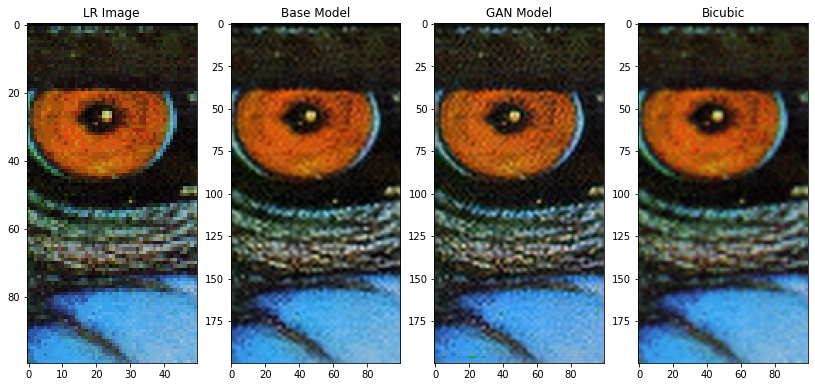

In [95]:
# Change "Set14" to another directory to load its images.
test_imgs_paths = get_paths(dirs, "Set14")
b_box = [0, 150, 100, 50]
image_test(test_imgs_paths[0], SCALE, base_model, "Base Model",
            generator, "GAN Model", b_box)

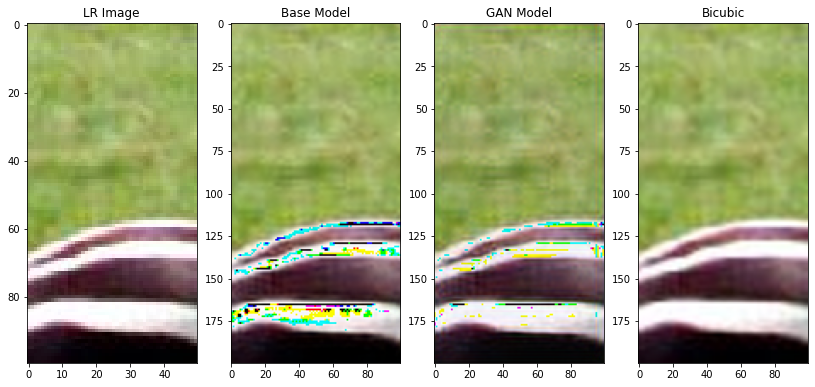

In [101]:
test_imgs_paths = get_paths(dirs, "Set14")
b_box = [0, 150, 100, 50]
image_test(test_imgs_paths[-1], SCALE, base_model, "Base Model",
            generator, "GAN Model", b_box)

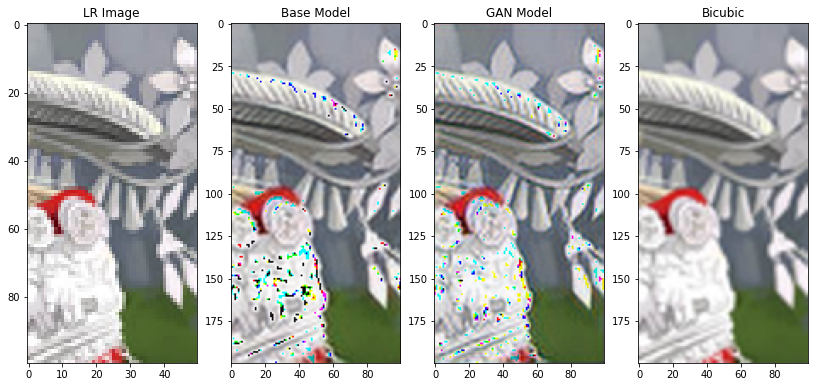

In [112]:
test_imgs_paths = get_paths(dirs, "Set14")
b_box = [0, 150, 100, 50]
image_test(test_imgs_paths[4], SCALE, base_model, "Base Model",
            generator, "GAN Model", b_box)

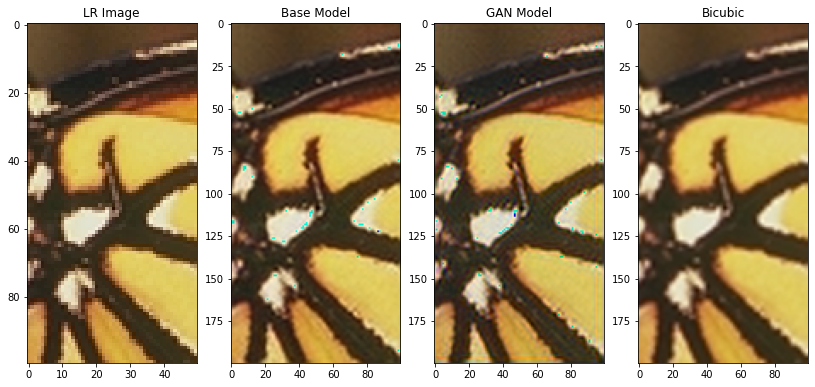

In [111]:
test_imgs_paths = get_paths(dirs, "Set14")
b_box = [150, 300, 100, 50]
image_test(test_imgs_paths[10], SCALE, base_model, "Base Model",
            generator, "GAN Model", b_box)

## Finish